In [1]:
import pandas as pd
from pandas import DataFrame, Series
import csv
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from sklearn.linear_model import LinearRegression

# In this project, I will be examining trends in global temperatures from the 18th century onwards and creating visuals to convey general conclusions. 

### Before going any further, I will open the data files and format them.

In [2]:
country_temps=pd.read_csv("GlobalLandTemperaturesByCountry.csv")
country_dates=country_temps['dt']
country_temps_average=country_temps.groupby("dt").mean()
world_temps=pd.read_csv("GlobalTemperatures.csv")
world_dates=world_temps['dt']
world_Landtemps_average=world_temps.groupby("dt").mean()
maj_city_temps=pd.read_csv("GlobalLandTemperaturesByMajorCity.csv")
maj_city_dates=maj_city_temps['dt']
maj_city_temps_avg=maj_city_temps.groupby("dt").mean()
state_temps=pd.read_csv("GlobalLandTemperaturesByState.csv")
state_dates=state_temps['dt']
state_temps_average=state_temps.groupby("dt").mean()
city_temps=pd.read_csv("GlobalLandTemperaturesByCity.csv")
city_dates=city_temps['dt']
city_temps_average=city_temps.groupby("dt").mean()


In [3]:
country_temps

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


# The following code will create four graph to display how the average temperature worldwide has changed each year. 
## The average temperature has been consistently increasing since the 18th century. In some graphs, there is a surge in the mid-1800s.
## Uncertainty about the data was much higher earlier on, but leveled off with time. 
### I created graphs using multiple datasets to ensure that the results were consistent. Each dataset provides temperatures monthly, but I averaged them out yearly to make the graphs more legible. 

In [4]:
#This function groups the country data by year
def group_by_year(DF, column):  
    year=None
    num_months=0  #This will track how many months of each year has data. 
    yearly_average_temp=0
    dict_years={}
    iloc=0
    for entry in DF.index: #Iterates through each date.
        iloc+=1
        if year==None:
            year=str(entry)[:4] 
            yearly_average_temp+=DF.loc[entry][column] #Adds current year's temperature to the yearly_average_temp variable.
        elif str(entry)[:4]==year:
            if not math.isnan(DF.loc[entry][column]): 
                yearly_average_temp+=DF.loc[entry][column]
                num_months+=1     
        elif str(entry)[:4]!=year or iloc==len(DF): #If the function has encountered a new year or reached the end of the dataframe. 
            if num_months !=0: #This checks if there were any entries in the current year. 
                dict_years[year]=(yearly_average_temp/num_months) #Records the average temperature of the current year.
            yearly_average_temp=0 
            if not math.isnan(DF.loc[entry][column]): #If the first entry of the new year is not NaN, then the temperature will be recorded.
                num_months=1
                yearly_average_temp+=DF.loc[entry][column]
            else:
                num_months=0
            year=str(entry)[:4]
    return (dict_years)
def graph_data(data, uncertainty,type_data):    
    #The code below creating a linear regression line is from https://realpython.com/linear-regression-in-python/
    #Creating a dataframe from the yearly averages and formatting it properly. 
    all_centuries_df=DataFrame([data]) #Data is a dict of the average temperature each year.
    all_centuries_df=all_centuries_df.T
    all_centuries_df.reset_index(inplace=True)
    all_centuries_df.columns =['year', 'temp'] 
    all_centuries_df["uncertainty"]=uncertainty.values()
    #Creating a linear regression line
    x = all_centuries_df["year"].to_numpy().reshape((-1, 1)).astype(np.int) #Turns the 1D array of years into a 2D array
    y = all_centuries_df["temp"].to_numpy().astype(np.float)
    model = LinearRegression().fit(x, y)
    r_sq=model.score(x, y)#Returns r^2 
    intercept= float(model.intercept_)
    slope=float(model.coef_)
    all_centuries_df["year"]=all_centuries_df["year"].astype("int64")#Setting the years column to type int. 
    #The line of code above is required for the next line to work, as the years column was previously type str.
    all_centuries_df["fit"] = (all_centuries_df["year"] * float(slope)) + float(intercept)#Obtains y values through the formula y=mx+b.
    fig, axs = plt.subplots(2,1,figsize=(7.5,7.5)) 
    plt.subplots_adjust(hspace=.33)
    plot_area=all_centuries_df.plot.line(x='year', y='fit', c='purple', ax=axs[0])
    #In order to color-code the graph, I need to group the data by the century.
    list_centuries=[]
    for entry in all_centuries_df["year"]:
        year=str(entry) #Above I changed the entries in the year column to int. However in order to execute the line below
        #it needs to be type str
        list_centuries.append(year[:2]+"00s") #This way, entries from the years 1752 1713 1763 1794 will all be grouped as "1700s" (for example).
    all_centuries_df["century"]=list_centuries #Adds an extra column to the dataframe denoting which century each entry is classified into.
    colors = ["blue", "green", "orange", "red"]
    markers = ["o", "^", "v", ","]
    centuries=set(sorted(list_centuries))
    #The for loop will make a plot for each century in the data set and graph it using the items in the lists "color" and "marker".
    #The loop is copied from a lecture in the class Data Programming 220 at UW Madison
    for variety in centuries: #variety is each century, so it is '1700s', '1800s', etc.
        sub_df = all_centuries_df[all_centuries_df["century"]==variety] #Creating a temporary dataframe containing all entries from the 1700s, then the 1800s, etc. 
        plot_area = sub_df.plot.scatter(x="year", y="temp",ax=axs[0], #Plots all data from the current century using the first entry in the color and label list, then removing that entry. 
                                        color=colors.pop(0),
                                        label=variety, marker=markers.pop(0)) 

    plot_area.set_xlabel("Year")
    plot_area.set_ylabel("Temperature")
    plot_area.set_title("Change in Average Temperature Each Year")
    #Plotting the error margin. 
    yerr=[]
    #I am adding the annual average uncertainty entries to a list. 
    for entry in  all_centuries_df["uncertainty"]:
        yerr.append(entry)
    fig = plt.figure()
    #In the expressions x.tolist() and y.tolist(), x and y are are created above when plotting a scatterplot. X is the years columnn of the all_centuries_df dataframe and y is the temperatures.
    x_axis=x.tolist() 
    y_axis=y.tolist()
    axs[1].errorbar(x=x, y=y, yerr=yerr, ls='none') #Plotting the errorbar onto the second subplot at the second row.
    axs[1].set_title("Average Uncertainty Each Year")
    axs[1].set_xlabel("Year")
    axs[1].set_ylabel("Average Uncertainty")
    plt.show()
    print("The coefficient of determination is", r_sq)
    print ("The data above is from the", type_data,"data set.")
    #This works properly because yerr, x, and y allcome from the same DataFrame. Consequently, they will be sorted in the same way and thus line up with each other.


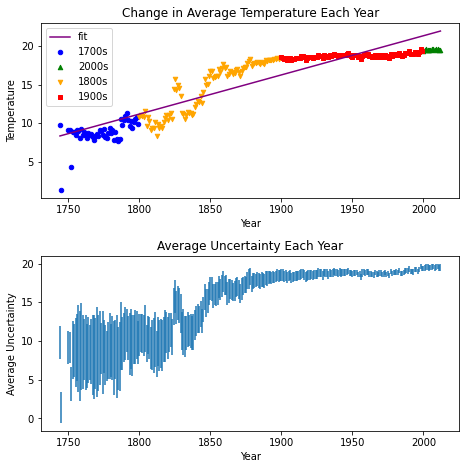

<Figure size 432x288 with 0 Axes>

The coefficient of determination is 0.8322364167832591
The data above is from the country temperatures data set.


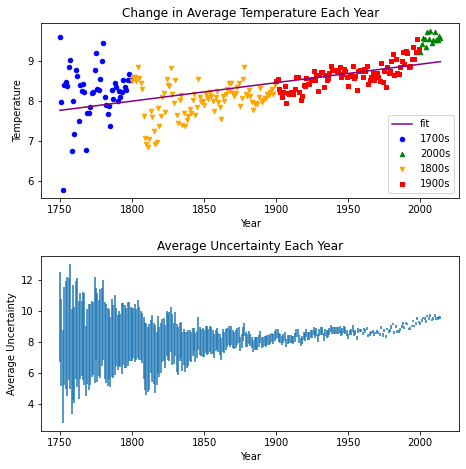

<Figure size 432x288 with 0 Axes>

The coefficient of determination is 0.36278299432134464
The data above is from the world temperatures data set.


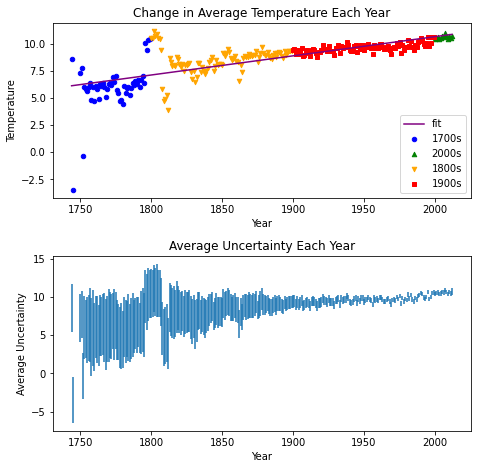

<Figure size 432x288 with 0 Axes>

The coefficient of determination is 0.5521250477380276
The data above is from the state temperatures data set.


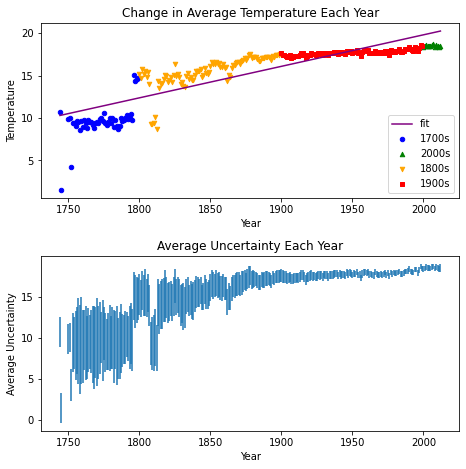

<Figure size 432x288 with 0 Axes>

The coefficient of determination is 0.7468693180564441
The data above is from the city temperatures data set.


In [5]:
#Graphing the average temperature and uncertainty across different data sets.

graph_data(group_by_year(country_temps_average, "AverageTemperature"), group_by_year(country_temps_average, "AverageTemperatureUncertainty"),"country temperatures")
graph_data(group_by_year(world_Landtemps_average, "LandAverageTemperature"), group_by_year(world_Landtemps_average, "LandAverageTemperatureUncertainty"),"world temperatures")
graph_data(group_by_year(state_temps_average, "AverageTemperature"), group_by_year(state_temps_average, "AverageTemperatureUncertainty"),"state temperatures")
graph_data(group_by_year(city_temps_average, "AverageTemperature"), group_by_year(city_temps_average, "AverageTemperatureUncertainty"),"city temperatures")

# Below, I will display which areas have had the highest increase in temperature. 
## It is important to note that different areas began recording temperatures at different times. As a result, places that began recording later will have fewer low temperatures recorded (due to the consistent increase in temperatures with time), weighing down their average. To avoid a possible misrepresentation, I grouped the areas based on when they began recording. 

In [6]:
def group_by_century(df, place_type):
    curr_place=None
    century_began={1700:[], 1750:[],1800:[], 1850:[],1900:[], 1950:[],2000:[]} #Each place will be placed in a list depending on when it began recording temperatures.
    index=1
    avg_temps=df.groupby(place_type).mean()
    avg_temps['AverageTemperature'] = avg_temps['AverageTemperature'].replace(np.nan, 0)
    for column in df: #This loop will figure out the indeces of the "dt" column and the place name column. 
        if column=="dt":
            dt_index=index
        elif column==place_type:
            place_index=index
        index+=1
    index=0
    for row in df.itertuples(): #This will iterate through each entry in the data frame. 
        dt,place=row[dt_index],row[place_index]
        if curr_place==place: #If curr_place==place, then we are not at the place's first entry (when they began recording temperatures). We only need the first entry of each place.
            continue
        elif curr_place==None or curr_place!=place: 
            curr_place=place
            year_began=int(dt[:4])#This will record the year of the first year a place began recording temperatures.
        #The conditionals below will classify the place based on when it began recording temperatures.
        if int(str(year_began)[2])<5:#If the third number of the year is less than 5 (e.g. 1846 4<5).
            century_began[int(str(year_began)[:2]+"00")].append([curr_place,index,avg_temps.loc[curr_place]["AverageTemperature"]])#This takes the first two numbers of the yera (which tells us the century) and adds 00 to it. It needs to temporarily be a string to concatonate the two. E.g. 1846 will become 1800.
        else:
            century_began[int(str(year_began)[:2]+"50")].append([curr_place,index,avg_temps.loc[curr_place]["AverageTemperature"]])
        index+=1
    return century_began
def highest_avg(century_began, type_place, index1, index2):
    highest_places,highest_temps=[],[]
    for century in century_began:
        if len(century_began[century])>0:#If no areas began recording temperatures after a specific time period like 2000, the list would be empty.
            sorted_list=sorted(century_began[century], key = lambda x: int(x[2]), reverse=True) #Sorts the list by average temperature. It's fine to hardcode the index of average temperature because the code that creates the list ensures that an average temperature is always recorded.
            #If a place had no recorded temperatures (resulting in the average temperature being NaN), it was replaced with 0.0 in the group_by_century function to act as a placeholder of sorts. 
            if sorted_list[0][2]>0.0: 
                highest_places.append(sorted_list[0][0])
                highest_temps.append(sorted_list[0][2])
    
    bar_top_temps = timeAxs[index1][index2].bar(highest_places, highest_temps, color=['b','r','g','orange','purple','pink','orange'])
    #The code below is from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
    colors = {'1700':'blue', '1750':'red', '1800':'green','1850':'orange', '1900': 'purple', '1950': 'pink', '2000': "yellow"}         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    #The code below is from https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 1),prop={'size': 12.5})
    timeAxs[index1][index2].set(xlabel=type_place, ylabel='Temperature')
    timeAxs[index1][index2].set_xticks(range(len(highest_places))) #This sets the tick locations based on how many entries are in the list.
    timeAxs[index1][index2].set_xticklabels(labels=highest_places,rotation=25)


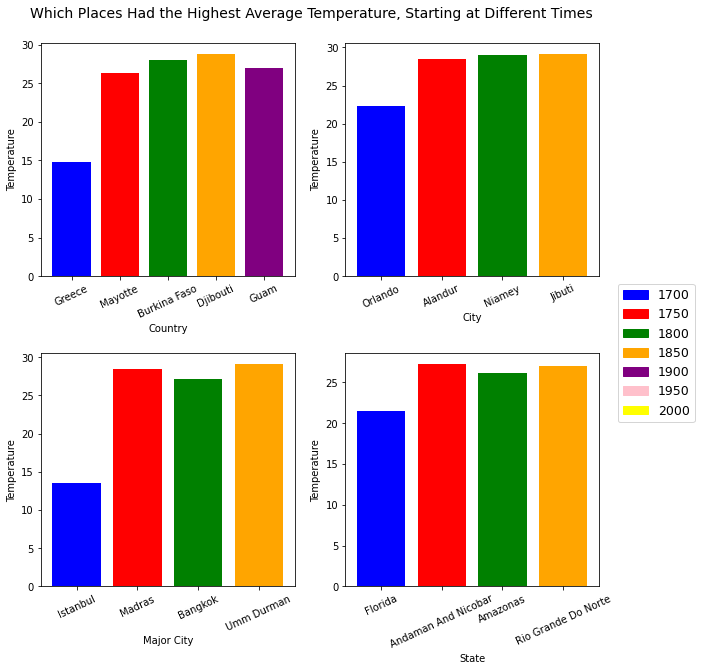

In [7]:
fig, timeAxs=plt.subplots(2,2, figsize=(10,10)) 
plt.subplots_adjust(hspace=.33)
plt.suptitle("Which Places Had the Highest Average Temperature, Starting at Different Times", fontsize=14,y=.93)
highest_avg(group_by_century(country_temps, "Country"), "Country",0,0)
highest_avg(group_by_century(city_temps, "City"), "City",0,1)
highest_avg(group_by_century(maj_city_temps, "City"), "Major City",1,0)
highest_avg(group_by_century(state_temps, "State"), "State",1,1)


# Lastly, I drew a map using the latitude and longitude of each entry in the city temperatures data set to display the heat distribution in each century. Because there was little data in the 18th century, its map is less filled out than the others. 

In [8]:
def heat_detector(DF,century,index1,index2):
    x=[]
    y=[]
    c=[]
    lat=0
    long=0
    for city in DF.groupby("City"):
        #The code below will check the direction oof the latitude/longitude then append it to the list of x/y coordinates.
        if str(city[1]["Latitude"].iloc[0]).endswith("N"): 
            lat=float(city[1]["Latitude"].iloc[0][:-1])
        elif str(city[1]["Latitude"].iloc[0]).endswith("S"):
            lat=-float(city[1]["Latitude"].iloc[0][:-1])
        if str(city[1]["Longitude"].iloc[0]).endswith("E"):
            long=float(city[1]["Longitude"].iloc[0][:-1])
        elif str(city[1]["Longitude"].iloc[0]).endswith("W"):
            long=-float(city[1]["Longitude"].iloc[0][:-1])
        x.append(long)
        y.append(lat)
    for row in DF.groupby("City").mean().reset_index().iterrows():
        c.append(row[1]["AverageTemperature"]) #The higher the average temperature, the brighter the ddot will be.
    if index1==0 and index2==0:#The colorbar only needs to be plotted once. Plotting it multiple times will result in overlap. To pevent this, I used a simple conditional to ensure it's only plotted when both indeces equal 0, which will only occur once.
        #The following two lines are from https://stackoverflow.com/questions/13310594/positioning-the-colorbar.
        img=heatAxs[index1][index2].scatter(x,y,c=c,cmap="inferno")
        cbaxes = fig.add_axes([.95, 0.15, 0.03, 0.7]) 
        cb = plt.colorbar(img, cax = cbaxes)  
        cb.ax.set_ylabel('Temperature')
    else:
        heatAxs[index1][index2].scatter(x,y,c=c,cmap="inferno")
    heatAxs[index1][index2].set_xlim(-200, 200) #Longitude has a minimum/maximum value of -180/180, so I rounded the limits up to 200.
    heatAxs[index1][index2].set_ylim(-100, 100)#Longitude has a minimum/maximum value of -90/90, so I rounded the limits up to 100.
    heatAxs[index1][index2].set_title(century+" Century")
    heatAxs[index1][index2].set(xlabel='Longitudde', ylabel='Latitude')
    

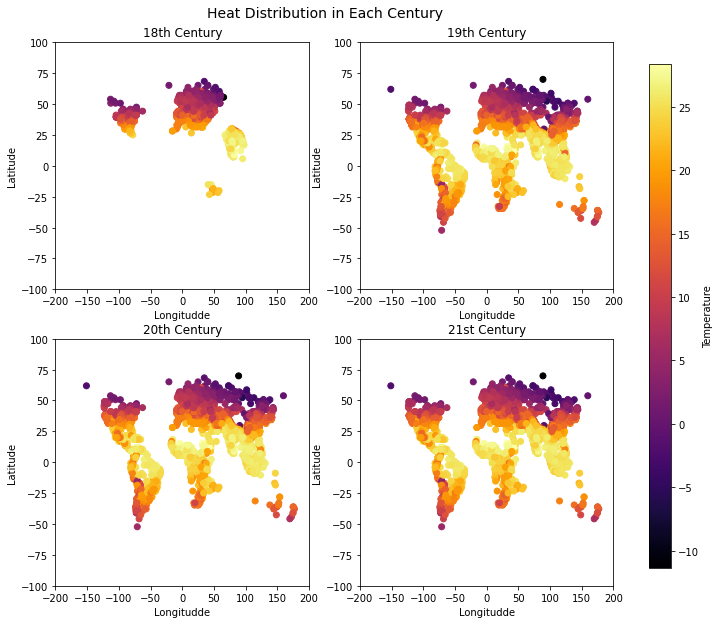

In [9]:
fig, heatAxs=plt.subplots(2,2, figsize=(10,10)) 
plt.suptitle("Heat Distribution in Each Century", fontsize=14,y=.93)
heat_detector(city_temps[city_temps["dt"].str.startswith('17', na=False)],"18th",0,0)
heat_detector(city_temps[city_temps["dt"].str.startswith('18', na=False)],"19th",0,1)
heat_detector(city_temps[city_temps["dt"].str.startswith('19', na=False)],"20th",1,0)
heat_detector(city_temps[city_temps["dt"].str.startswith('20', na=False)],"21st",1,1)
